In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops import rnn, rnn_cell
%matplotlib inline

Lets create a data set for our simple example. 

In [2]:
x_train = np.asarray(np.arange(-2, 2, 0.005), dtype='f')

In [10]:
# Shape of the data points 
print x_train.shape

(800,)


In [4]:
#Lets create a function to approximate 
y_train = np.sin(x_train*1.5 * np.pi)

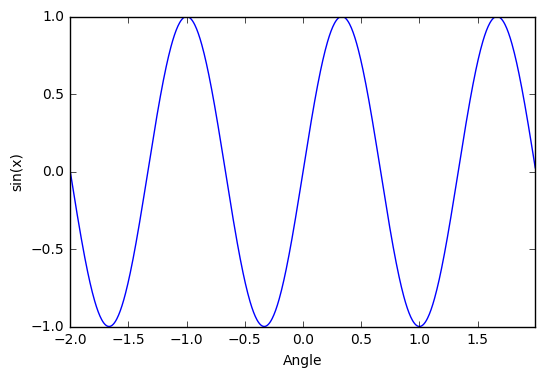

In [11]:
#PLot the function 
plt.plot(x_train, y_train)
plt.xlabel('Angle')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [6]:
#Parameters
d_input = 1
d_output = 1
d_hidden = 20
n_steps = 1
learning_rate = 0.001

In [7]:
#Weights and Biases defined
weights = {
    'hidden': tf.Variable(tf.random_normal([d_input, d_hidden])), 
    'out': tf.Variable(tf.random_normal([d_hidden, d_output]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([d_hidden])),
    'out': tf.Variable(tf.random_normal([d_output]))
}

In [8]:
def _RNN(_X, _istate, _W, _b, _nsteps, _name):
    
    _X = tf.transpose(_X, [1, 0, 2])
    _X = tf.reshape(_X, [-1, d_input])
    _H = tf.matmul(_X, _W['hidden']) + _b['hidden']
    _Hsplit = tf.split(0, _nsteps, _H) 
  
    with tf.variable_scope(_name):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(d_hidden, forget_bias=1.0)
        _LSTM_O, _LSTM_S = tf.nn.rnn(lstm_cell, _Hsplit, initial_state=_istate)
    _O = tf.matmul(_LSTM_O[:], _W['out']) + _b['out']    
    return {
        'X': _X, 'H': _H, 'Hsplit': _Hsplit,
        'LSTM_O': _LSTM_O, 'LSTM_S': _LSTM_S, 'O': _O 
    }
print ("Network ready")

Network ready


In [9]:
x      = tf.placeholder("float", [None, n_steps, d_input])
y      = tf.placeholder("float", [None, d_output])
istate = tf.placeholder("float", [None, 2*d_hidden]) #state & cell => 2x n_hidden
myrnn  = _RNN(x, istate, weights, biases, n_steps, 'basic')

pred   = myrnn['O']
cost   = tf.reduce_mean(tf.pow(pred-y, 2)) 
optm   = tf.train.AdamOptimizer(learning_rate).minimize(cost) # Adam Optimizer
accr   = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1), tf.argmax(y,1)), tf.float32))
init   = tf.initialize_all_variables()
print ("Initalize all variable")

ValueError: Shape (200, ?, 20) must have rank 2

In [ ]:
training_epochs = 300
batch_size      = 200
display_step    = 50

sess = tf.Session()
sess.run(init)

#summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs', graph=sess.graph)
print ("Start optimization")

for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(x_train.shape[0]/batch_size)
    # Loop over all batches
    for i in range(4):
        batch_xs = x_train[i*batch_size*n_steps:(i+1)*batch_size*n_steps]
        batch_ys = y_train[i*batch_size*n_steps:(i+1)*batch_size*n_steps]
        batch_ys =np.matrix(np.reshape(batch_ys,[200,1]))
    
        batch_xs = np.reshape(batch_xs,[batch_size, n_steps, d_input])

        # Fit training using batch data
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, istate: np.zeros((batch_size, 2*d_hidden))})
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys 
                                              , istate: np.zeros((batch_size, 2*d_hidden))})/4
    # Display logs per epoch step
    if epoch % display_step == 0: 
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys, istate: np.zeros((batch_size, 2*d_hidden))})
        print (" Training accuracy: %.3f" % (train_acc))
#         testimgs = testimgs.reshape((ntest, nsteps, diminput))
#         test_acc = sess.run(accr, feed_dict={x: testimgs, y: testlabels, istate: np.zeros((ntest, 2*d_hidden))})
#         print (" Test accuracy: %.3f" % (test_acc))
print ("Optimization Finished.")

In [11]:
x_test = x_train[:200] # Lets see how well it fits

x_test = np.reshape(x_test,[1,200,1])
myrnn  = sess.run(myrnn, feed_dict={x: x_test, istate: np.zeros((1, 2*d_hidden))})
print myrnn['O']

[[-0.21469682]]


In [10]:
print np.asarray(myrnn['LSTM_O']).shape
print myrnn['LSTM_O'][:].shape


NameError: name 'myrnn' is not defined